<a href="https://colab.research.google.com/github/shivamoop/logo_detection/blob/main/Logo_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q ultralytics opencv-python pandas numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount("/content/drive")


In [3]:

import os

PROJECT_ROOT = "/content/drive/MyDrive/logo_detection_nike_adidas"

DIRS = [
    PROJECT_ROOT,
    f"{PROJECT_ROOT}/data",
    f"{PROJECT_ROOT}/models",
    f"{PROJECT_ROOT}/videos",
    f"{PROJECT_ROOT}/csv",
    f"{PROJECT_ROOT}/logs",
]

for d in DIRS:
    os.makedirs(d, exist_ok=True)

print("Project directories created in Google Drive")


Project directories created in Google Drive


In [4]:
NIKE_PATH   = "/content/drive/MyDrive/nike.v2-nike.yolov8"
ADIDAS_PATH = "/content/drive/MyDrive/Adidas-alpha.v1-adidas.yolov8"

import os
print("Nike files:", len(os.listdir(NIKE_PATH)))
print("Adidas files:", len(os.listdir(ADIDAS_PATH)))


Nike files: 6
Adidas files: 6


In [5]:
import os

def show_tree(p):
    for i in os.listdir(p):
        print(i)

print("NIKE:")
show_tree(NIKE_PATH)
print("\nADIDAS:")
show_tree(ADIDAS_PATH)


NIKE:
README.dataset.txt
data.yaml
README.roboflow.txt
valid
test
train

ADIDAS:
data.yaml
README.roboflow.txt
README.dataset.txt
valid
test
train


In [7]:
import glob

def check_labels(root):
    bad = []
    for lbl in glob.glob(f"{root}/**/labels/*.txt", recursive=True):
        for line in open(lbl):
            parts = line.strip().split()
            if len(parts) < 5:
                bad.append((lbl, line))
                continue
            c, x, y, w, h = map(float, parts[:5])
            if not (0 <= x <= 1 and 0 <= y <= 1 and 0 < w <= 1 and 0 < h <= 1):
                bad.append((lbl, line))
    print(root, "bad labels:", bad[:3])

check_labels(NIKE_PATH)
check_labels(ADIDAS_PATH)


/content/drive/MyDrive/nike.v2-nike.yolov8 bad labels: []
/content/drive/MyDrive/Adidas-alpha.v1-adidas.yolov8 bad labels: []


In [9]:
from ultralytics import YOLO
YOLO("yolov8n.pt").predict(
    source=f"{NIKE_PATH}/train/images",
    save=True, conf=0.01, verbose=False
)


Results saved to /content/runs/detect/predict2


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

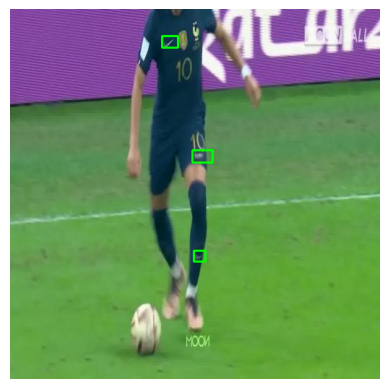

In [10]:
import cv2
import matplotlib.pyplot as plt

img_path = "/content/drive/MyDrive/nike.v2-nike.yolov8/train/images/random_968_jpg.rf.7fe746d444aca3b2c461cd3c7cc972ae.jpg"
lbl_path = img_path.replace("/images/", "/labels/").replace(".jpg", ".txt")

img = cv2.imread(img_path)
h, w = img.shape[:2]

with open(lbl_path) as f:
    for line in f:
        c, x, y, bw, bh = map(float, line.split()[:5])
        x1 = int((x - bw/2) * w)
        y1 = int((y - bh/2) * h)
        x2 = int((x + bw/2) * w)
        y2 = int((y + bh/2) * h)
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")


In [11]:
PROJECT_ROOT = "/content/drive/MyDrive/logo_detection_nike_adidas"

MERGED_DATA = f"{PROJECT_ROOT}/data_merged"
for split in ["train", "valid", "test"]:
    os.makedirs(f"{MERGED_DATA}/images/{split}", exist_ok=True)
    os.makedirs(f"{MERGED_DATA}/labels/{split}", exist_ok=True)

print("Merged dataset directories created")


Merged dataset directories created


In [12]:
import shutil

def merge_dataset(src_root, class_id, prefix):
    for split in ["train", "valid", "test"]:
        img_src = f"{src_root}/{split}/images"
        lbl_src = f"{src_root}/{split}/labels"

        img_dst = f"{MERGED_DATA}/images/{split}"
        lbl_dst = f"{MERGED_DATA}/labels/{split}"

        for img_name in os.listdir(img_src):
            if not img_name.lower().endswith((".jpg",".png",".jpeg")):
                continue

            new_img = f"{prefix}_{img_name}"
            shutil.copy2(
                f"{img_src}/{img_name}",
                f"{img_dst}/{new_img}"
            )

            lbl_name = img_name.rsplit(".",1)[0] + ".txt"
            src_lbl = f"{lbl_src}/{lbl_name}"
            dst_lbl = f"{lbl_dst}/{new_img.rsplit('.',1)[0] + '.txt'}"

            with open(src_lbl) as r, open(dst_lbl, "w") as w:
                for line in r:
                    parts = line.strip().split()
                    w.write(f"{class_id} " + " ".join(parts[1:]) + "\n")

merge_dataset(NIKE_PATH,   0, "nike")
merge_dataset(ADIDAS_PATH, 1, "adidas")

print("Merge + remap completed")


Merge + remap completed


In [16]:
with open(f"{MERGED_DATA}/data.yaml","w") as f:
    f.write(f"""
path: {MERGED_DATA}
train: images/train
val: images/valid
test: images/test

names:
  0: Nike
  1: Adidas
""")

print("data.yaml created")

DATA_YAML = "/content/drive/MyDrive/logo_detection_nike_adidas/data_merged/data.yaml"



data.yaml created


In [14]:
def count_imgs(p): return len([f for f in os.listdir(p) if f.endswith((".jpg",".png",".jpeg"))])
def count_lbls(p): return len([f for f in os.listdir(p) if f.endswith(".txt")])

for split in ["train","valid","test"]:
    print(
        split.upper(),
        "Images:", count_imgs(f"{MERGED_DATA}/images/{split}"),
        "Labels:", count_lbls(f"{MERGED_DATA}/labels/{split}")
    )


TRAIN Images: 239 Labels: 239
VALID Images: 47 Labels: 47
TEST Images: 29 Labels: 29


In [15]:
from ultralytics import YOLO
model = YOLO("yolov8m.pt")
model.info()


YOLOv8m summary: 169 layers, 25,902,640 parameters, 0 gradients, 79.3 GFLOPs


(169, 25902640, 0, 79.3204224)

In [17]:
model.train(
    data=DATA_YAML,
    imgsz=768,
    epochs=100,
    batch=8,
    optimizer="AdamW",
    lr0=3e-4,
    weight_decay=1e-4,
    patience=10,
    device=0,
    project=PROJECT_ROOT,
    name="baseline_yolov8m_768",
    workers=2,
    cache=False,
    close_mosaic=10
)

Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/logo_detection_nike_adidas/data_merged/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=768, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_yolov8m_768, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_ma

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f0e1c5b7290>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [24]:
model = YOLO("/content/drive/MyDrive/logo_detection_nike_adidas/baseline_yolov8m_768/weights/best.pt")


img = cv2.imread("/content/random_968_jpg.rf.2b51c17cb0a3474e800934c7acd3cd7d.jpg")
OUT_PATH   = "/content/drive/MyDrive/logo_detection_nike_adidas/annotated_test.jpg"


h, w = img.shape[:2]

MIN_AREA = 0.0003   # 0.03%
MAX_AREA = 0.08     # 8%


results = model(img, conf=0.15)[0]

for box in results.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    cls = int(box.cls[0])
    conf = float(box.conf[0])
    label = model.names[cls]

    bw = (x2 - x1) / w
    bh = (y2 - y1) / h
    area = bw * bh

    if MIN_AREA <= area <= MAX_AREA:
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(
            img,
            f"{label} {conf:.2f}",
            (x1, y1-6),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0,255,0),
            2
        )

cv2.imwrite(OUT_PATH, img)
print("Saved annotated image to:", OUT_PATH)


0: 768x768 3 Nikes, 47.3ms
Speed: 3.9ms preprocess, 47.3ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 768)
Saved annotated image to: /content/drive/MyDrive/logo_detection_nike_adidas/annotated_test.jpg


In [25]:
MODEL_PATH = "/content/drive/MyDrive/logo_detection_nike_adidas/baseline_yolov8m_768/weights/best.pt"
VIDEO_IN   = "/content/drive/MyDrive/input_cvat.mp4"
OUT_DIR    = "/content/drive/MyDrive/logo_detection_nike_adidas/video_chunks"

os.makedirs(OUT_DIR, exist_ok=True)

# load model
model = YOLO(MODEL_PATH)

# video props
cap = cv2.VideoCapture(VIDEO_IN)
fps = int(cap.get(cv2.CAP_PROP_FPS))
W   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
TOTAL_FRAMES = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# chunk settings
CHUNK_SIZE = 1000
OVERLAP    = 200
STEP       = CHUNK_SIZE - OVERLAP

# tuned thresholds (unchanged)
CONF_THRES = 0.15
MIN_AREA   = 0.0003
MAX_AREA   = 0.08

chunk_id = 0
start_frame = 0

while start_frame < TOTAL_FRAMES:
    end_frame = min(start_frame + CHUNK_SIZE, TOTAL_FRAMES)

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    out_path = f"{OUT_DIR}/chunk_{chunk_id:02d}.mp4"
    out = cv2.VideoWriter(
        out_path,
        cv2.VideoWriter_fourcc(*"mp4v"),
        fps,
        (W, H)
    )

    frame_idx = start_frame
    while frame_idx < end_frame:
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame, conf=CONF_THRES)[0]

        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            label = model.names[cls]

            bw = (x2 - x1) / W
            bh = (y2 - y1) / H
            area = bw * bh

            if MIN_AREA <= area <= MAX_AREA:
                cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)
                cv2.putText(
                    frame,
                    f"{label} {conf:.2f}",
                    (x1, y1-6),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,
                    (0,255,0),
                    2
                )

        out.write(frame)
        frame_idx += 1

    out.release()
    print(f"Saved chunk {chunk_id}: frames {start_frame}–{end_frame}")

    chunk_id += 1
    start_frame += STEP

cap.release()
print("All chunks processed")

Streaming output truncated to the last 5000 lines.
Speed: 5.6ms preprocess, 19.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 768)

0: 448x768 (no detections), 19.9ms
Speed: 4.8ms preprocess, 19.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 768)

0: 448x768 (no detections), 19.9ms
Speed: 4.1ms preprocess, 19.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 768)

0: 448x768 (no detections), 19.9ms
Speed: 6.2ms preprocess, 19.9ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 768)

0: 448x768 (no detections), 20.1ms
Speed: 4.7ms preprocess, 20.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 768)

0: 448x768 (no detections), 19.9ms
Speed: 8.1ms preprocess, 19.9ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 768)

0: 448x768 (no detections), 19.9ms
Speed: 5.4ms preprocess, 19.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 768)

0: 448x768 (no detections), 19.8ms
Speed: 4.1ms prepr

In [ ]:
import csv
MODEL_PATH = "/content/drive/MyDrive/logo_detection_nike_adidas/baseline_yolov8m_768/weights/best.pt"
VIDEO_IN   = "/content/drive/MyDrive/input_cvat.mp4"
CSV_DIR    = "/content/drive/MyDrive/logo_detection_nike_adidas/csv_chunks"

os.makedirs(CSV_DIR, exist_ok=True)

# model
model = YOLO(MODEL_PATH)

# video props
cap = cv2.VideoCapture(VIDEO_IN)
fps = int(cap.get(cv2.CAP_PROP_FPS))
W   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
TOTAL_FRAMES = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# chunk config
CHUNK_SIZE = 1000
OVERLAP    = 200
STEP       = CHUNK_SIZE - OVERLAP

# tuned filters (unchanged)
CONF_THRES = 0.15
MIN_AREA   = 0.0003
MAX_AREA   = 0.08

chunk_id = 0
start_frame = 0

while start_frame < TOTAL_FRAMES:
    end_frame = min(start_frame + CHUNK_SIZE, TOTAL_FRAMES)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    csv_path = f"{CSV_DIR}/chunk_{chunk_id:02d}.csv"
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "chunk_id",
            "frame_id",
            "timestamp_sec",
            "class",
            "confidence",
            "x1", "y1", "x2", "y2",
            "area_norm"
        ])

        frame_idx = start_frame
        while frame_idx < end_frame:
            ret, frame = cap.read()
            if not ret:
                break

            results = model(frame, conf=CONF_THRES)[0]

            for box in results.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                cls = int(box.cls[0])
                conf = float(box.conf[0])
                label = model.names[cls]

                bw = (x2 - x1) / W
                bh = (y2 - y1) / H
                area = bw * bh

                if MIN_AREA <= area <= MAX_AREA:
                    writer.writerow([
                        chunk_id,
                        frame_idx,
                        round(frame_idx / fps, 2),
                        label,
                        round(conf, 4),
                        x1, y1, x2, y2,
                        round(area, 6)
                    ])

            frame_idx += 1

    print(f"CSV saved: chunk_{chunk_id:02d}.csv  (frames {start_frame}–{end_frame})")

    chunk_id += 1
    start_frame += STEP

cap.release()
print("All chunk CSVs generated")


Streaming output truncated to the last 5000 lines.

0: 448x768 (no detections), 17.5ms
Speed: 6.7ms preprocess, 17.5ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 768)

0: 448x768 1 Adidas, 15.7ms
Speed: 6.0ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 768)

0: 448x768 1 Adidas, 17.7ms
Speed: 7.5ms preprocess, 17.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 768)

0: 448x768 1 Adidas, 17.2ms
Speed: 6.5ms preprocess, 17.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 768)

0: 448x768 1 Adidas, 14.1ms
Speed: 10.0ms preprocess, 14.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 768)

0: 448x768 (no detections), 18.6ms
Speed: 5.0ms preprocess, 18.6ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 768)

0: 448x768 (no detections), 14.8ms
Speed: 5.8ms preprocess, 14.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 768)

0: 448x768 (no detections), 14.5ms
Speed: 8.

In [ ]:
import cv2
import os

CHUNK_DIR = "/content/drive/MyDrive/logo_detection_nike_adidas/video_chunks"
FINAL_OUT = "/content/drive/MyDrive/logo_detection_nike_adidas/final_annotated_video.mp4"

# get sorted chunk list
chunks = sorted([
    os.path.join(CHUNK_DIR, f)
    for f in os.listdir(CHUNK_DIR)
    if f.endswith(".mp4")
])

assert len(chunks) > 0, "No chunk videos found"

# read properties from first chunk
cap0 = cv2.VideoCapture(chunks[0])
fps = int(cap0.get(cv2.CAP_PROP_FPS))
W   = int(cap0.get(cv2.CAP_PROP_FRAME_WIDTH))
H   = int(cap0.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap0.release()

out = cv2.VideoWriter(
    FINAL_OUT,
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (W, H)
)

for chunk_path in chunks:
    cap = cv2.VideoCapture(chunk_path)
    print("Merging:", os.path.basename(chunk_path))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)

    cap.release()

out.release()

print("Final merged video saved to:", FINAL_OUT)


In [ ]:
import pandas as pd
import os

CSV_DIR   = "/content/drive/MyDrive/logo_detection_nike_adidas/csv_chunks"
FINAL_CSV = "/content/drive/MyDrive/logo_detection_nike_adidas/final_detections.csv"

dfs = []

for f in sorted(os.listdir(CSV_DIR)):
    if f.endswith(".csv"):
        df = pd.read_csv(os.path.join(CSV_DIR, f))
        # keep only rows where a logo was detected
        df = df[df["class"].isin(["Nike", "Adidas"])]
        if len(df) > 0:
            dfs.append(df)

final_df = pd.concat(dfs, ignore_index=True)

final_df.to_csv(FINAL_CSV, index=False)
print("Final CSV saved to:", FINAL_CSV)
print("Total detections:", len(final_df))
